In [32]:
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.python.keras.layers import BatchNormalization


class SiameseNetwork:
    def __init__(self,
                 input_shape,
                 learning_rate=0.001,
                 momentum=0.5,
                 decay_rate=0.98,
                 use_sgd=True,
                 kernel_regularizer_conv=0.01,
                 kernel_regularizer_dense=0.0001):
        self._convolutional_network = Sequential()
        self._set_cnn(kernel_regularizer_conv, kernel_regularizer_dense)
        self.model = self._build_siamese_network(input_shape, learning_rate, momentum, decay_rate, use_sgd)

    def _add_convolutional_layer(self, filters, kernel_size, kernel_regularizer, add_pool):
        self._convolutional_network.add(Conv2D(filters=filters,
                                               kernel_size=kernel_size,
                                               activation='relu',
                                               kernel_initializer=RandomNormal(mean=0, stddev=0.01),
                                               bias_initializer=RandomNormal(mean=0.5, stddev=0.01),
                                               kernel_regularizer=l2(kernel_regularizer)))
        self._convolutional_network.add(BatchNormalization())

        if add_pool:
            self._convolutional_network.add(MaxPool2D())

    def _set_cnn(self, kernel_regularizer_conv, kernel_regularizer_dense):
        self._add_convolutional_layer(64, (10, 10), kernel_regularizer_conv, True)
        self._add_convolutional_layer(128, (7, 7), kernel_regularizer_conv, True)
        self._add_convolutional_layer(128, (4, 4), kernel_regularizer_conv, True)
        self._add_convolutional_layer(256, (4, 4), kernel_regularizer_conv, False)

        self._convolutional_network.add(Flatten())
        self._convolutional_network.add(Dense(units=4096,
                                              activation='sigmoid',
                                              kernel_initializer=RandomNormal(mean=0, stddev=0.01),
                                              bias_initializer=RandomNormal(mean=0.5, stddev=0.01),
                                              kernel_regularizer=l2(kernel_regularizer_dense)))

    def _build_siamese_network(self,
                               input_shape,
                               learning_rate=0.001,
                               momentum=0.5,
                               decay_rate=0.98,
                               use_sgd=True):

        input_image_1 = Input(input_shape)
        input_image_2 = Input(input_shape)

        output_image_1 = self._convolutional_network(input_image_1)
        output_image_2 = self._convolutional_network(input_image_2)

        l1_distance_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
        l1_distance = l1_distance_layer([output_image_1, output_image_2])

        prediction = Dense(units=1,
                           activation='sigmoid',
                           kernel_initializer=RandomNormal(mean=0, stddev=0.01),
                           bias_initializer=RandomNormal(mean=0.5, stddev=0.01))(l1_distance)
        model = Model(inputs=[input_image_1, input_image_2], outputs=prediction)

        if use_sgd:
            optimizer = SGD(learning_rate=ExponentialDecay(learning_rate, 100000, decay_rate),
                            momentum=momentum)
        else:
            optimizer = Adam(learning_rate=ExponentialDecay(learning_rate, 100000, decay_rate))

        model.compile(loss='binary_crossentropy',
                      metrics=['binary_accuracy'],
                      optimizer=optimizer)
        return model

    def fit(self, X, y, **kwargs):
        return self.model.fit(X, y, **kwargs)

    def evaluate(self, X, y, **kwargs):
        return self.model.evaluate(X, y, **kwargs)

    def predict(self, X):
        return self.model.predict(X)






In [33]:
import os

from data_loader import LFW2DataLoader
from siamese_network import SiameseNetwork
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
def plot_losses(history):
  plt.plot(history.history['binary_accuracy'])
  plt.plot(history.history['val_binary_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [36]:
train_file_path = 'pairsDevTrain.txt'
test_file_path = 'pairsDevTest.txt'
images_path = '/content/one-shot-face-recognition/lfw2/lfw2'

In [37]:
input_size = 105
data_loader = LFW2DataLoader((input_size, input_size), images_path)
train_X, train_y = data_loader.load_images_from_path(train_file_path)
test_X, test_y = data_loader.load_images_from_path(test_file_path)

In [38]:
input_shape = (input_size, input_size, 1)
model = SiameseNetwork(input_shape, learning_rate=0.0001, decay_rate=1, kernel_regularizer_conv=1e-4, use_sgd=False)

In [39]:
%%time
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=20, restore_best_weights=True)
history = model.fit(train_X,
                    train_y.astype(float),
                    batch_size=64,
                    validation_split=0.15,
                    epochs=200,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/200
30/30 [==============================] - 6s 170ms/step - loss: 1.0042 - binary_accuracy: 0.6717 - val_loss: 1.3469 - val_binary_accuracy: 0.0000e+00
Epoch 2/200
30/30 [==============================] - 5s 165ms/step - loss: 0.8523 - binary_accuracy: 0.7914 - val_loss: 1.3189 - val_binary_accuracy: 0.0000e+00
Epoch 3/200
30/30 [==============================] - 5s 169ms/step - loss: 0.7253 - binary_accuracy: 0.8914 - val_loss: 1.3033 - val_binary_accuracy: 0.0030
Epoch 4/200
30/30 [==============================] - 5s 171ms/step - loss: 0.5917 - binary_accuracy: 0.9647 - val_loss: 1.2729 - val_binary_accuracy: 0.0455
Epoch 5/200
30/30 [==============================] - 5s 171ms/step - loss: 0.4930 - binary_accuracy: 0.9957 - val_loss: 1.2360 - val_binary_accuracy: 0.1515
Epoch 6/200
30/30 [==============================] - 5s 169ms/step - loss: 0.4301 - binary_accuracy: 0.9995 - val_loss: 1.2376 - val_binary_accuracy: 0.2697
Epoch 7/200
30/30 [==============================]

Test evaluation (loss, Accuracy):  [0.8311034440994263, 0.7139999866485596]
Train evaluation (loss, Accuracy):  [0.2284652143716812, 0.9418181777000427]


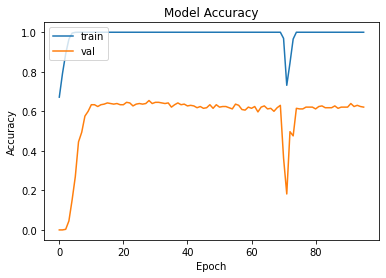

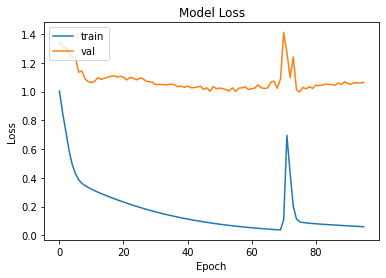

In [40]:
train_eval = model.evaluate(train_X, train_y, verbose=False)
test_eval = model.evaluate(test_X, test_y, verbose=False)

print('Test evaluation (loss, Accuracy): ', test_eval)
print('Train evaluation (loss, Accuracy): ', train_eval)
plot_losses(history)

In [41]:
def show_images(img1, img2, label):
  print('Same person' if label else 'Different People')
  plt.subplot(1,2,1)
  plt.imshow(img1 * 255, cmap='gray')
  plt.subplot(1,2,2)
  plt.imshow(img2 * 255, cmap='gray')
  plt.show()

In [42]:
test_predictions = model.predict(test_X)
test_predictions = (test_predictions >= 0.5).astype(int)

train_predictions = model.predict(train_X)
train_predictions = (train_predictions >= 0.5).astype(int)

Different People


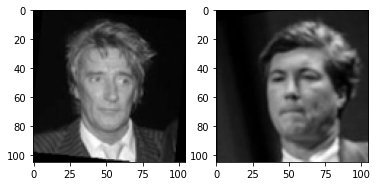

Different People


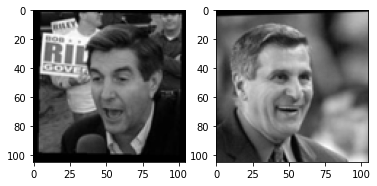

Different People


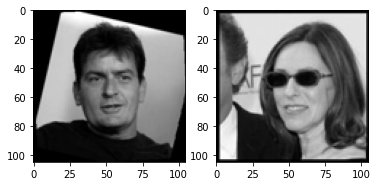

Different People


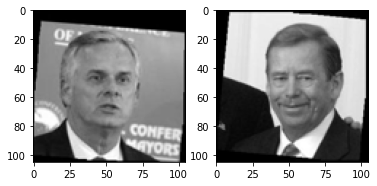

Different People


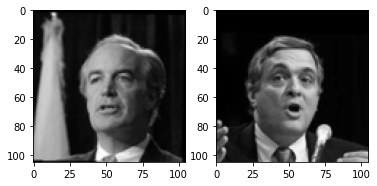

Different People


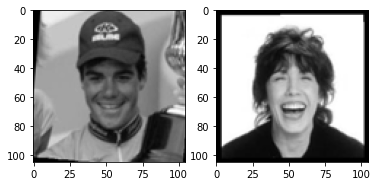

Different People


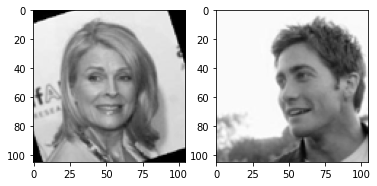

Same person


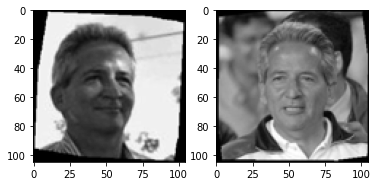

Different People


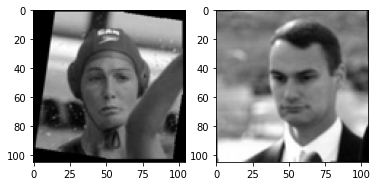

Same person


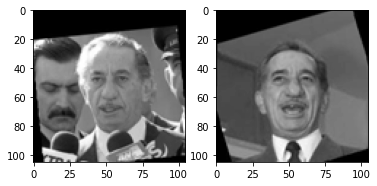

In [43]:
# Look at mistakes the model makes
import numpy as np

test_X_array = np.array(test_X_array)

mistakes = test_X_array[:, (test_predictions[:,0] != test_y), :, :, 0]
mistake_labels = test_y[(test_predictions[:,0] != test_y)]

random_mistakes = np.random.randint(0, mistakes.shape[0] - 1, 10)

for images, label in zip(mistakes[random_mistakes], mistake_labels[random_mistakes]):
  show_images(images[0], images[1], label)



Same person


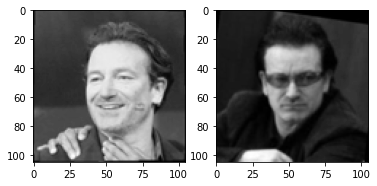

Different People


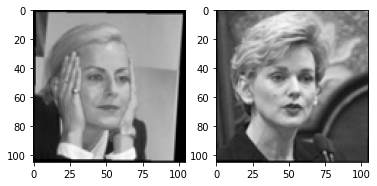

Different People


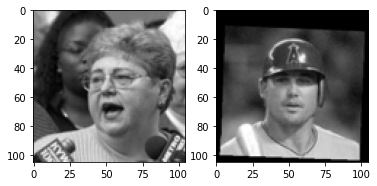

Different People


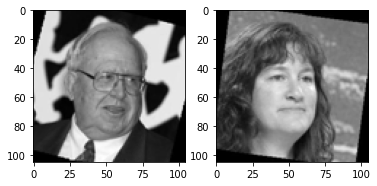

Different People


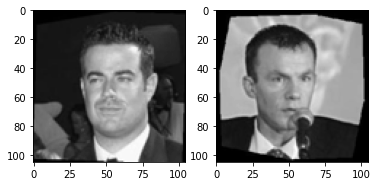

Different People


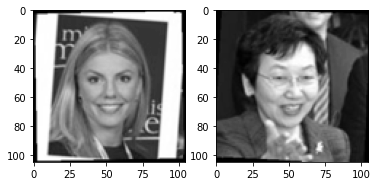

Different People


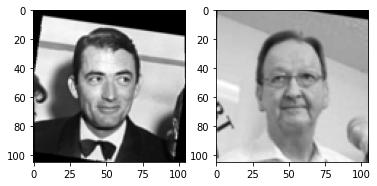

Same person


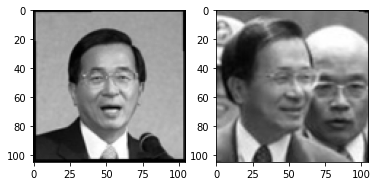

Same person


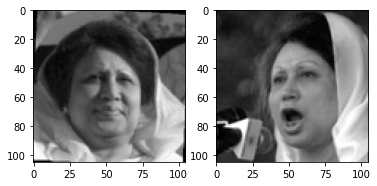

Same person


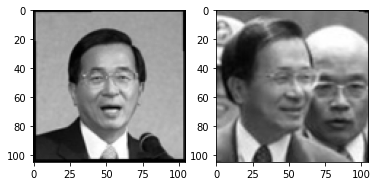

Different People


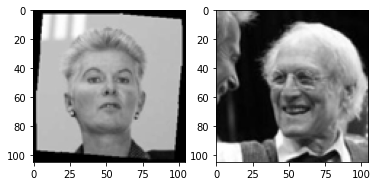

Different People


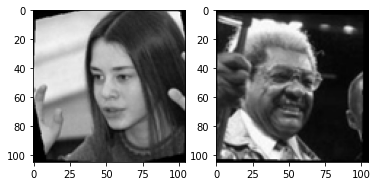

Same person


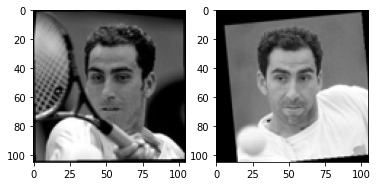

Same person


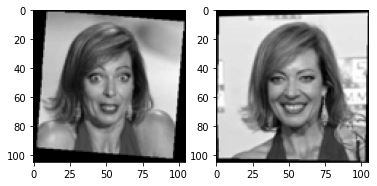

Same person


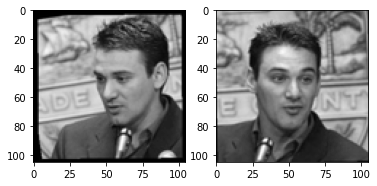

Same person


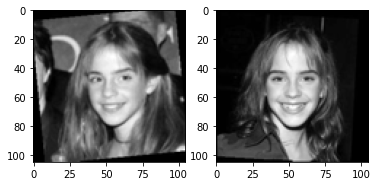

Same person


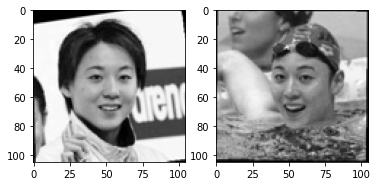

Different People


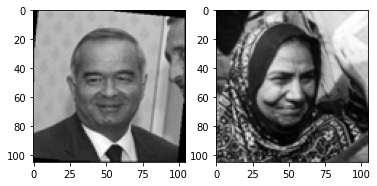

Same person


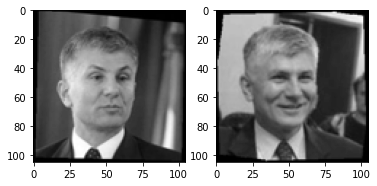

Same person


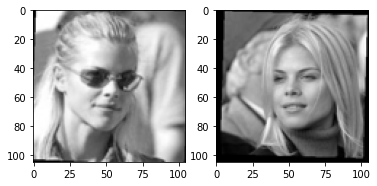

Different People


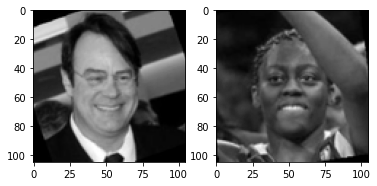

Same person


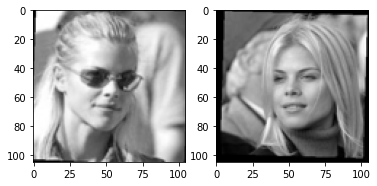

Same person


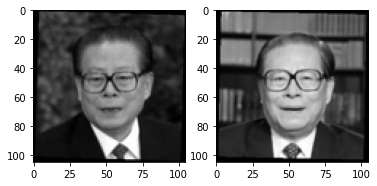

Different People


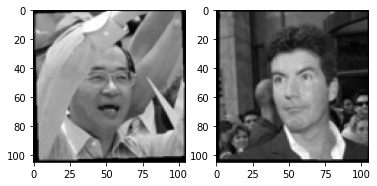

Different People


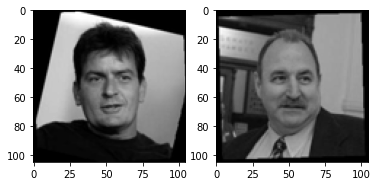

Different People


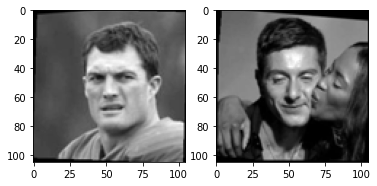

Same person


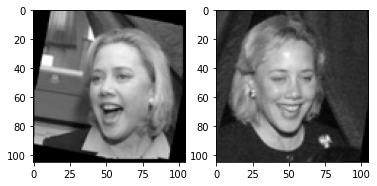

Same person


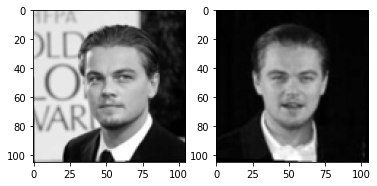

Different People


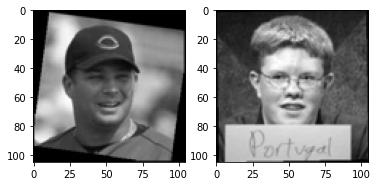

Same person


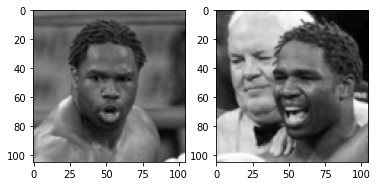

Same person


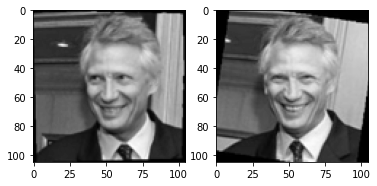

Same person


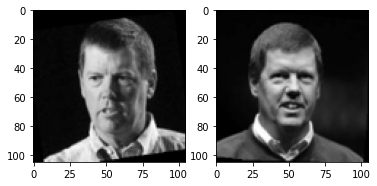

Same person


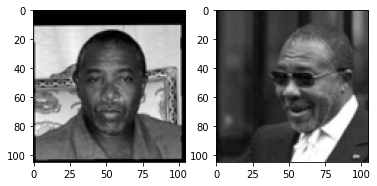

Same person


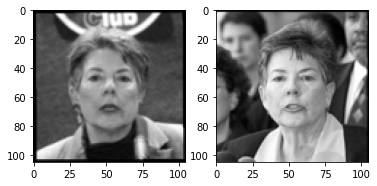

Different People


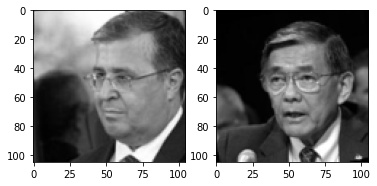

Same person


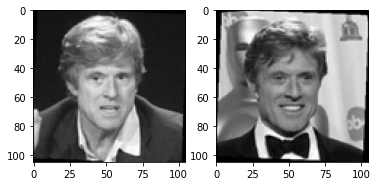

Same person


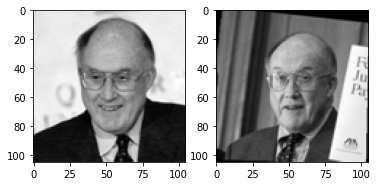

Same person


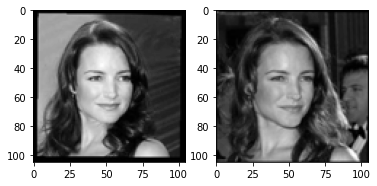

Same person


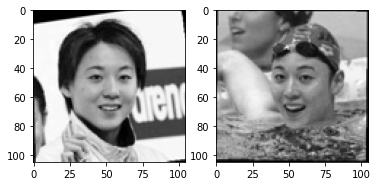

Different People


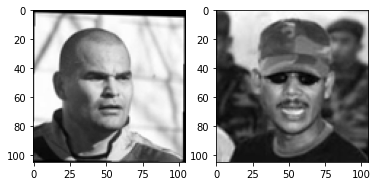

Same person


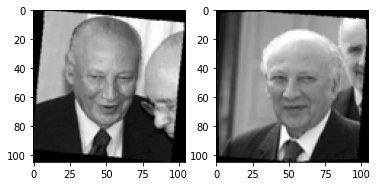

Different People


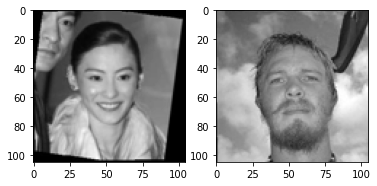

Same person


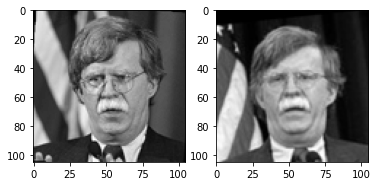

Different People


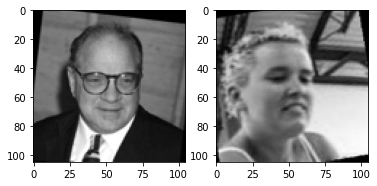

Same person


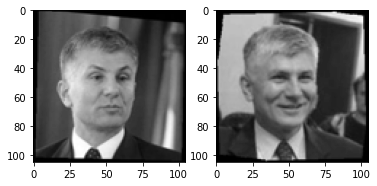

Same person


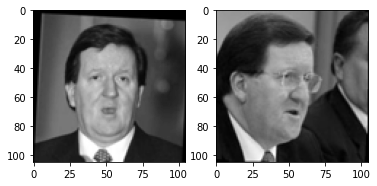

Same person


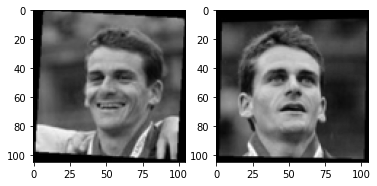

Same person


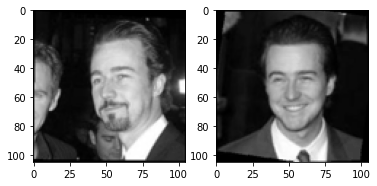

Same person


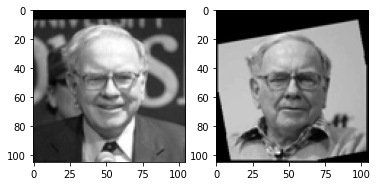

Same person


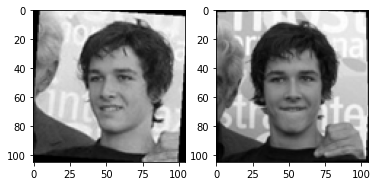

Same person


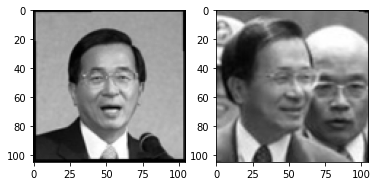

Same person


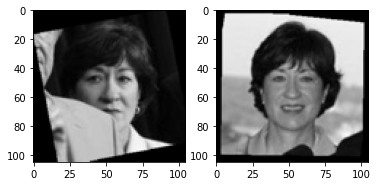

Same person


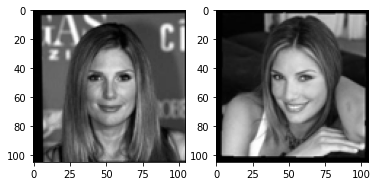

Same person


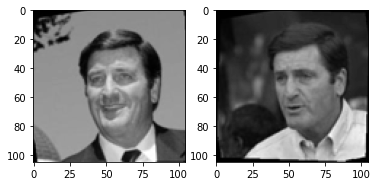

Same person


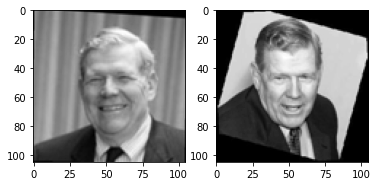

Different People


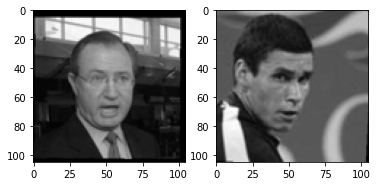

Different People


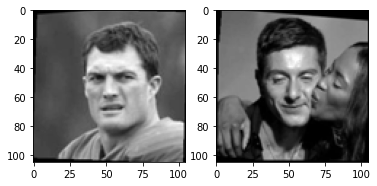

Different People


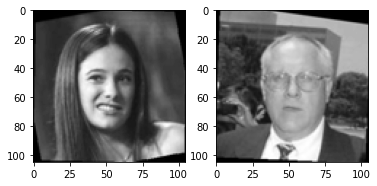

Same person


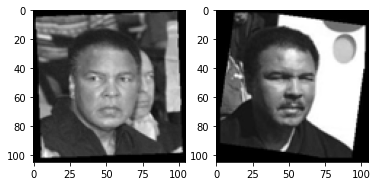

Different People


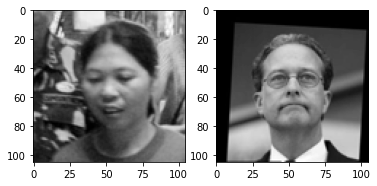

Different People


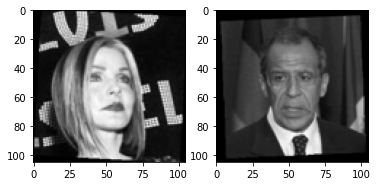

Different People


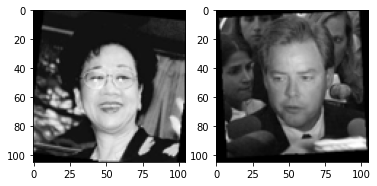

Different People


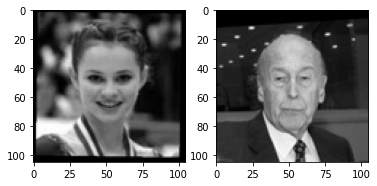

Different People


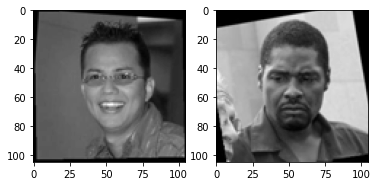

Same person


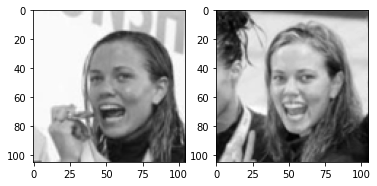

Different People


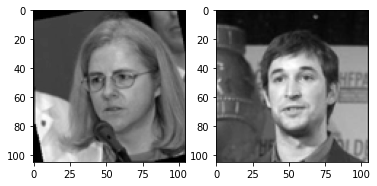

Different People


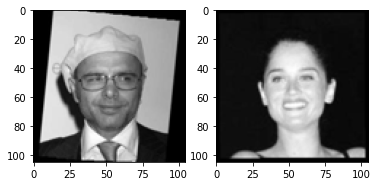

Different People


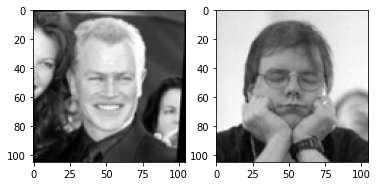

Different People


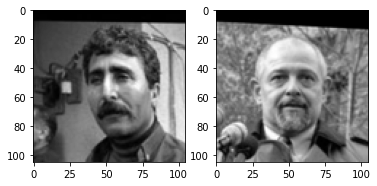

Same person


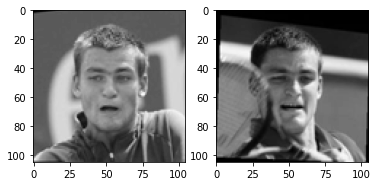

Different People


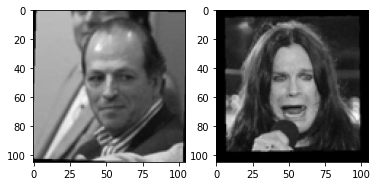

Same person


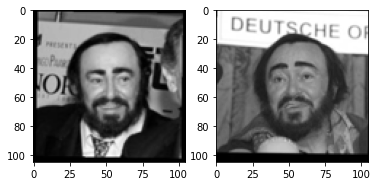

Same person


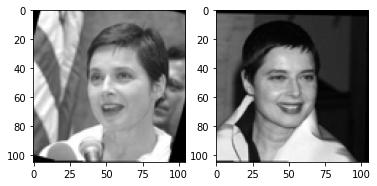

Same person


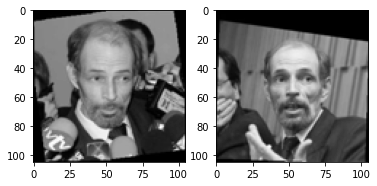

Same person


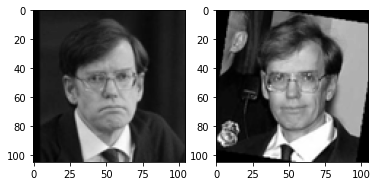

Same person


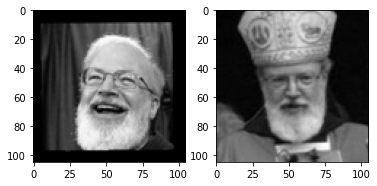

Same person


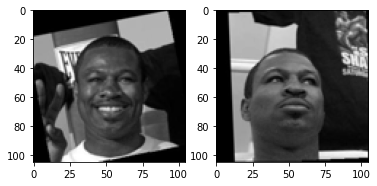

Different People


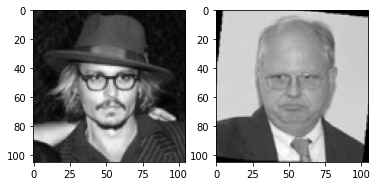

Same person


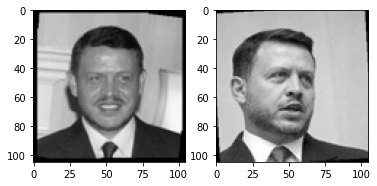

Different People


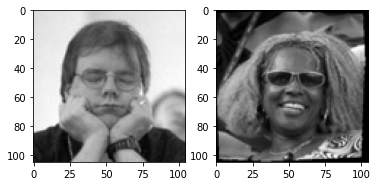

Different People


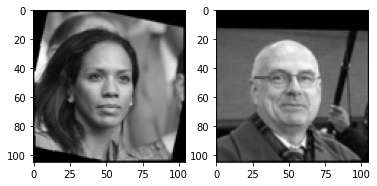

Same person


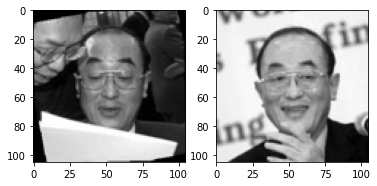

Same person


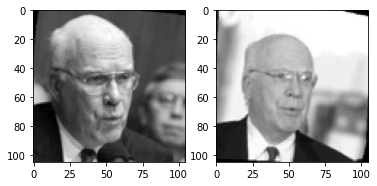

Same person


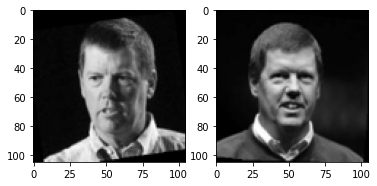

Same person


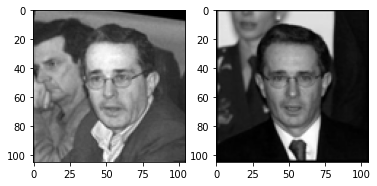

Same person


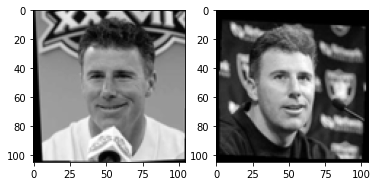

Same person


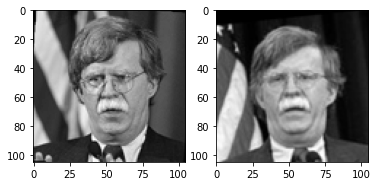

Same person


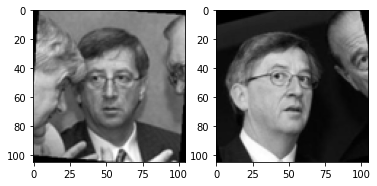

Different People


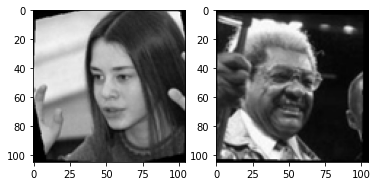

Same person


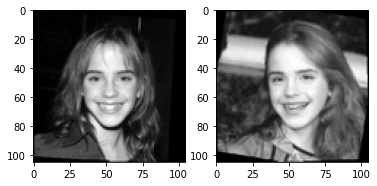

Same person


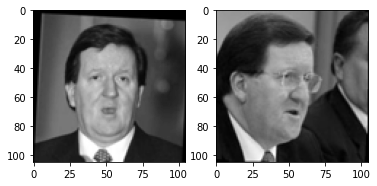

Same person


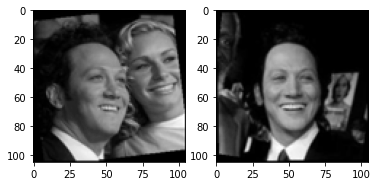

Different People


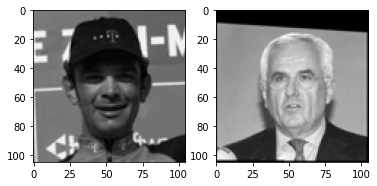

Different People


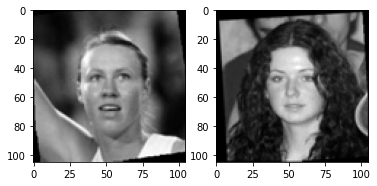

Different People


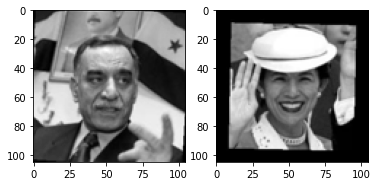

Same person


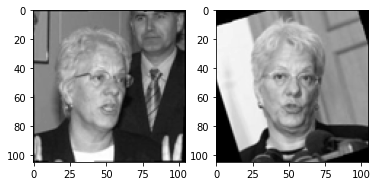

Same person


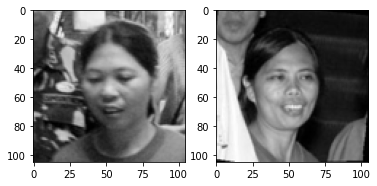

Different People


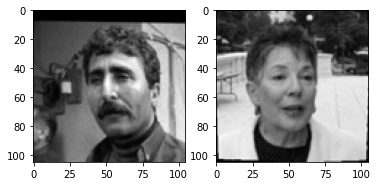

Different People


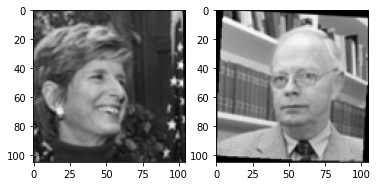

Same person


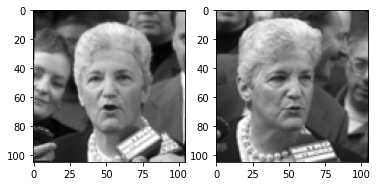

In [44]:
# Look at correct classifications
correct = test_X_array[:, (test_predictions[:,0] == test_y), :, :, 0]
correct_labels = test_y[(test_predictions[:,0] == test_y)]

random_correct = np.random.randint(0, correct.shape[0] - 1, 100)

for images, label in zip(correct[random_correct], correct_labels[random_correct]):
  show_images(images[0], images[1], label)